# SEG-Y reader

[SEG-Y](http://www.agilegeoscience.com/blog/2014/3/26/what-is-seg-y.html)  file format is one of several standards developed by the Society of Exploration Geophysicists (**SEG**) for storing geophysical data. It is an open standard, and is controlled by the **SEG Technical Standards Committee**, a non-profit organization.

<div align="center">
    <img width=700 src="https://static.squarespace.com/static/549dcda5e4b0a47d0ae1db1e/54a06d6ee4b0d158ed95f696/54a06d6fe4b0d158ed95ff08/1395799000963/1000w/SEGY_file_byte_stream_structure.png" title="SEG-Y file format"</img>
    <small>source: [AgileGeoscience](http://www.agilegeoscience.com/blog/2014/3/26/what-is-seg-y.html)</small>
</div>
<br/>

The format can accommodate a variety of industry-specific meta-data, for example, source sweep information and trace identification code (uphole, water break, etc), and legacy meta-data, such as the tape reel number, in the binary header within the SEG-Y file.<br/>
<br/>
A SEG-Y file typically contains all the traces which recorded a given source and is commonly referred to as a shot gather, or the file may contain traces from a single receiver which recorded a large number of sources and is known as a receiver gather.  Each trace within the gather is limited to 32767 samples.<br/>
<br/>
**SEG-Y format is being used by most of the seismic acquisition companies whose clients are the largest oil companies in the world**. 
<br/>
<br/>
In this notebook we will use [ObsPy](https://github.com/obspy/obspy/wiki) Python package to visualise several SEG-Y files.

First we will load the libraries and modules that we will be using:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.signal
from obspy.segy.segy import readSEGY

# Loading SEG-Y data with ObsPy

Let's load a SEG-Y first. We will use 2D lines taken from the [USGS Alaska land dataset](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx).

In [2]:
# SEG-Y file
file1 = 'SEGY/16_81_PT1_PR.SGY'
segy1=readSEGY(file1,unpack_headers=True)

We can look at the EBCDIC header (i.e., the textual header that is supposed to contain all sort of important information) and the binary header:

In [3]:
segy1.textual_file_header

'C01 CLIENT/JOB ID    1 8 1 4 2 6 8 3                                            C02 LINE    16X                                                                 C03 REEL NO 810604181418   DAY-START OF REEL  04       YEAR 1981                C04 INSTRUMENT: MFG TI          MODEL ASC                                       C05 DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  C06 SAMPLE RATE   0000004000 US  SAMPLES/TRACE  1501BITS/IN 1600 BYTES/SAMPLE 4 C07 RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 C08 SAMPLE CODE: FLOATING PT 4 BYTE                                             C09 GAIN TYPE:   FLOATING PT                                                    C10                                                                             C11                                                                             C12                                                                             C13                                    

In [4]:
print segy1.binary_file_header.sample_interval_in_microseconds
print segy1.binary_file_header.line_number
print segy1.binary_file_header.number_of_samples_per_data_trace

4000
16
1501


We will define a function that takes the SEG-Y structure created by `ObsPy` and gives us back all the data we will need, i.e.:

* `output`, NumPy array containing the actual data
* `twt`, the z-axis vector (standard acronym for "two-way-time", but you can call it `meters` if what you're loading a PSDM volume)
* `nsamples`, number of samples
* `sr`, sample rate
* `clip_val`, recommended clip value to display the data

In [5]:
def copy_segy(inputsegy,lag):
    
    ntraces=len(inputsegy.traces)
    nsamples=inputsegy.binary_file_header.number_of_samples_per_data_trace
    sr=inputsegy.binary_file_header.sample_interval_in_microseconds
    twt=np.arange(lag,lag+nsamples*sr/1000.,sr/1000.)
    output = np.zeros((nsamples, ntraces))  # shape=row,column --> twt i.e. nsamples, ntraces
    
    for i, trace in enumerate(inputsegy.traces):
        output[:,i] = trace.data
    clip_val = abs(np.percentile(output, 0.999))   # default clip value
    
    print 'number of traces/samples/sample rate :', ntraces, nsamples, sr
    print 'first / last sample twt              :', twt[0], twt[-1]
    print 'value to clip data display           :', clip_val
    return output, ntraces, nsamples, sr, twt, clip_val

Let's try it:

In [6]:
(line1,nt1,ns1,sr1,twt1,clip1) = copy_segy(segy1,0)

number of traces/samples/sample rate : 1912 1501 4000
first / last sample twt              : 0.0 6000.0
value to clip data display           : 1667.94457527


So we know that we have 1912 traces, each traces is made of 1501 samples, which multiplied by the sample rate (4 microseconds) gives us 6 seconds of data. So our numpy array `line1` will have this shape - remember that a numpy array is (_rows_,_columns_):

In [7]:
line1.shape

(1501, 1912)

# Display the seismic

We define a simple function to do a quick plot of the data:

In [8]:
def plot_seismic(inputseis,twt,name,colr=None,clip_val=None):
    
    ntraces=np.shape(inputseis)[1]
    
    if clip_val is None:
        clip_val=abs(np.percentile(inputseis, 0.999))   # default clip value
    if colr is None:
        colr=cm.seismic # altre opzioni possibili: cm.gray,cm.coolwarm, cm.RdGy
        
    f, ax = plt.subplots(figsize=(16,6),facecolor='w')
    im=ax.imshow(inputseis,interpolation='bilinear',aspect='auto',cmap=colr,extent=(0,ntraces,twt[-1],twt[0]),vmin=-clip_val,vmax=clip_val)
    plt.xlabel('Trace no.'), plt.ylabel('Two-way time [ms]')
    plt.title(name), plt.grid(), plt.colorbar(im)

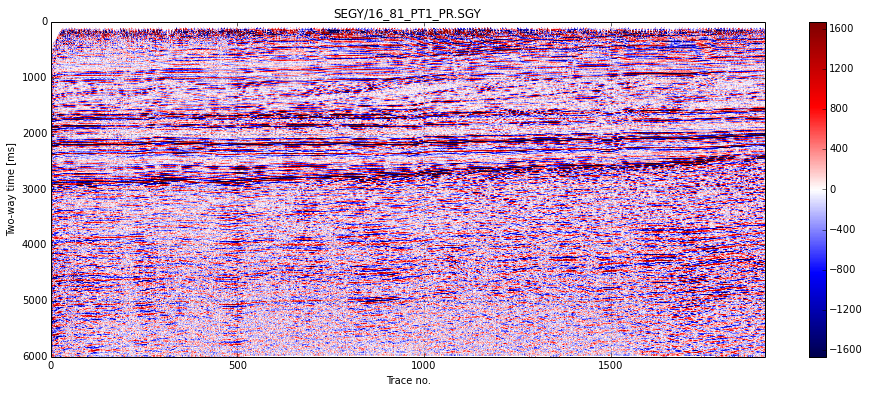

In [22]:
plot_seismic(line1,twt1,file1)

Another example, this time with a gray colorbar:

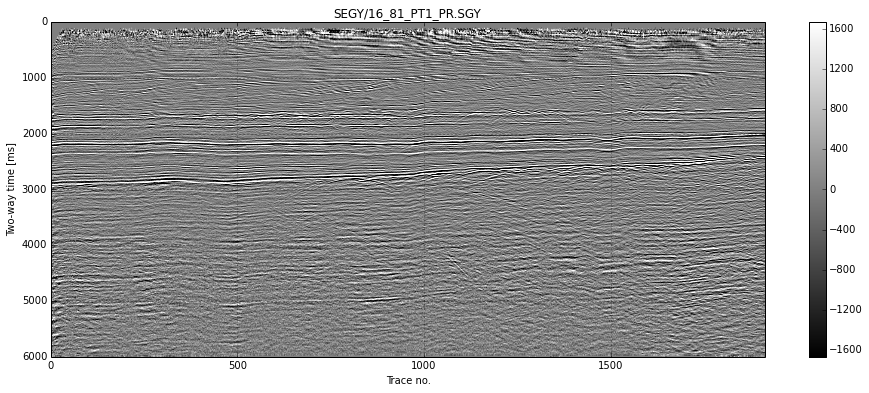

In [23]:
plot_seismic(line1,twt1,file1,colr=cm.gray)

This is a way to zoom in, for example in the window from 1 to 2 seconds (_Don't forget the data are in milliseconds_):

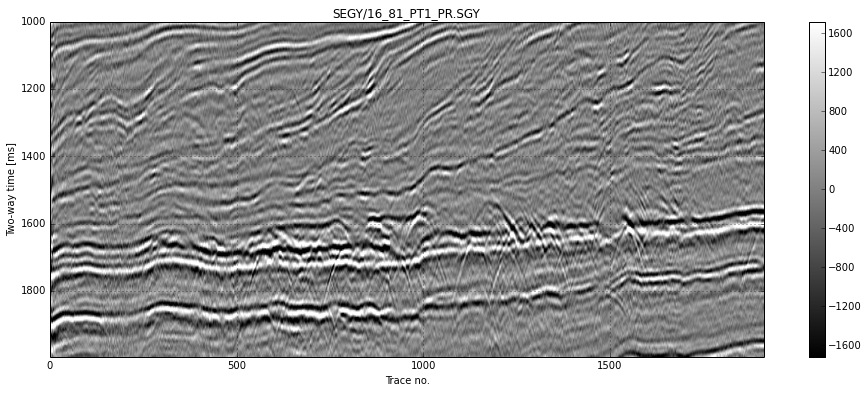

In [24]:
uu=1000; ll=2000

line1_zoom=line1[twt1.tolist().index(uu):twt1.tolist().index(ll),:]
twt1_zoom=twt1[twt1.tolist().index(uu):twt1.tolist().index(ll)]

plot_seismic(line1_zoom,twt1_zoom,file1,colr=cm.gray)

As you can see, in the `plot_seismic` function you can also choose your preferred colormaps (it defaults to the classic red-blue seismic map). 

<br/>
<br/>

<font color='red'>**Try also `cm.seismic`, `cm.coolwarm`, `cm.RdGy`**</font>

(More information on colormap with IPython could be found [here](http://nbviewer.ipython.org/github/mycarta/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb) and [there]( https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/)).

All the colormaps available in [matplotlib](http://matplotlib.org/) are listed here:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps 

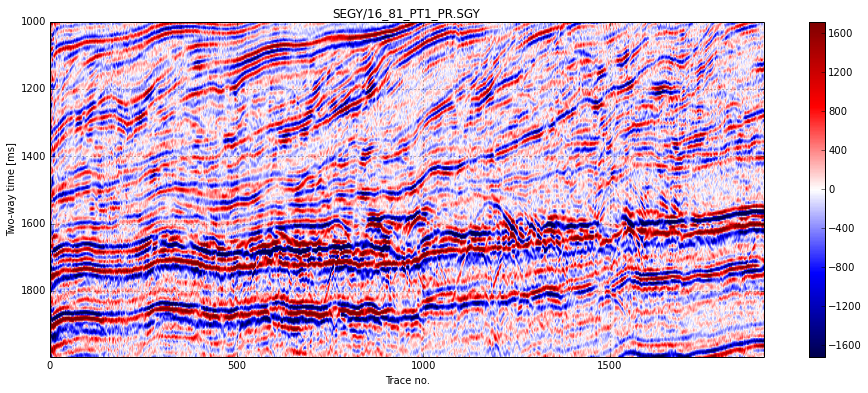

In [26]:
# WRITE YOUR CODE HERE

# Comparison displays

Let's assume we want to build a comparison display to see two (or more) lines at once. For the demonstration we will create 2 other versions of the same line.

So let's create one version with noise added and another one with a smoothing filter applied (code for adding noise and smoothing the data are taken from [this notebook by Matt Hall](http://nbviewer.ipython.org/github/agile-geoscience/notebooks/blob/master/Filtering_horizons.ipynb):

In [28]:
noise = np.random.uniform(-500,500, line1_zoom.shape)
line1_noise = line1_zoom + noise

kernel = np.ones((5,5)) / 25
line1_filt = scipy.signal.convolve2d(line1_zoom, kernel)

Let's see them all:

<matplotlib.colorbar.Colorbar instance at 0x7f494eb0f7e8>

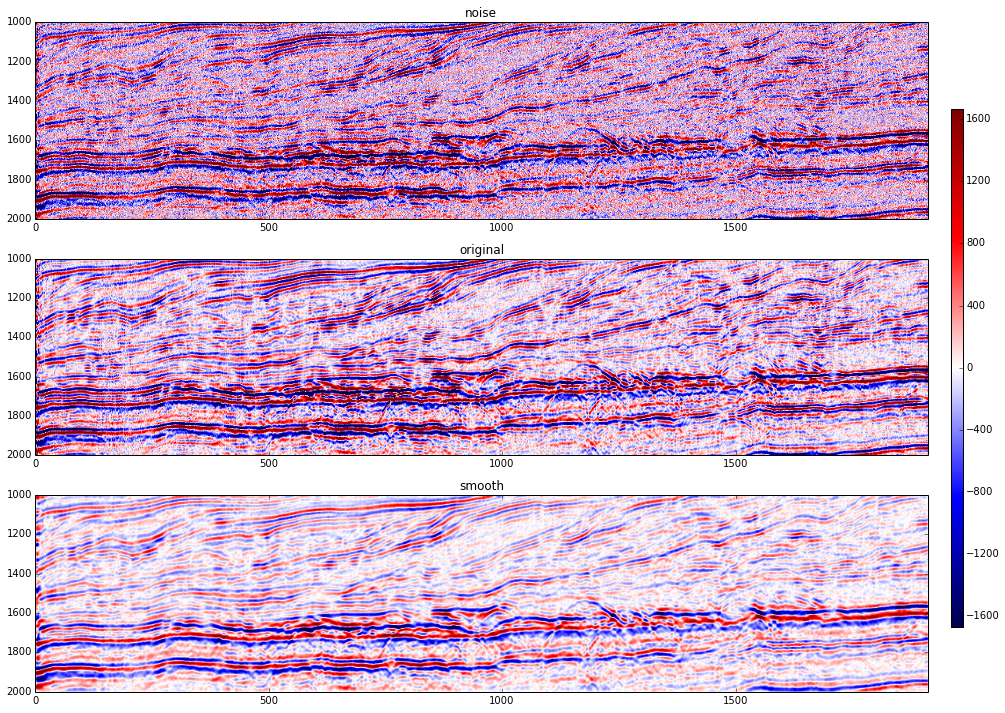

In [30]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(16,12),facecolor='w')
im0=ax[0].imshow(line1_noise,interpolation='bilinear',aspect='auto',cmap=cm.seismic,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
im1=ax[1].imshow(line1_zoom, interpolation='bilinear',aspect='auto',cmap=cm.seismic,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
im2=ax[2].imshow(line1_filt, interpolation='bilinear',aspect='auto',cmap=cm.seismic,extent=(0,nt1,ll,uu),vmin=-clip1,vmax=clip1)
ax[0].set_title('noise'), ax[1].set_title('original'), ax[2].set_title('smooth')
cax = f.add_axes([0.92, 0.2, 0.01, 0.6])
f.colorbar(im0, cax=cax, orientation='vertical')

Load SEG-Y file: `16_81_PT2_PR.SGY`.

<br/>
<font color='red'>**For this new loaded file and using the example shown above:**</font>

1. <font color='red'>display the 2D seismic line,</font>
2. <font color='red'>create a noise and smooth version of the loaded seismic line and </font>
3. <font color='red'> perform a multi-plot visualisation zooming on a window from 1 to 3 seconds</font>

number of traces/samples/sample rate : 2040 1501 4000
first / last sample twt              : 0.0 6000.0
value to clip data display           : 1781.43644804


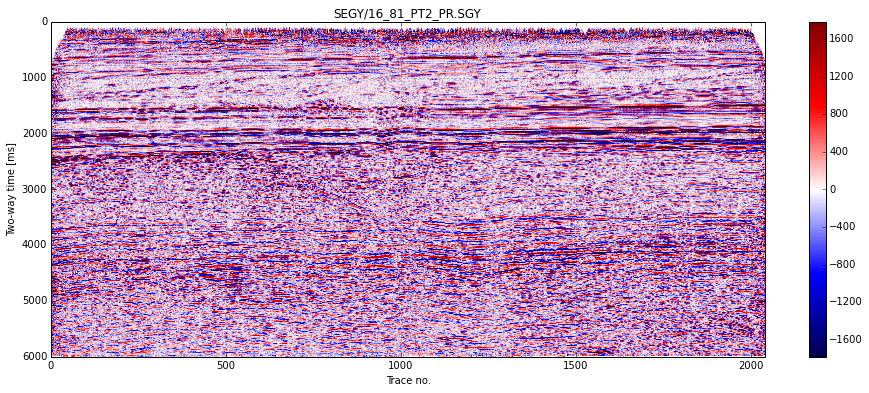

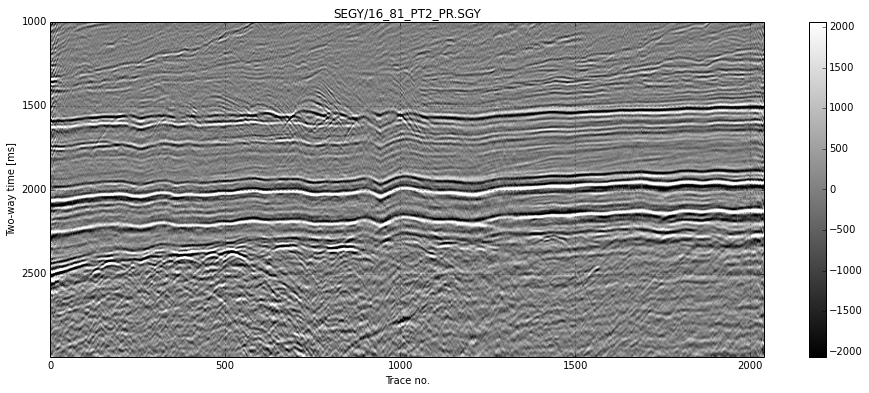

<matplotlib.colorbar.Colorbar instance at 0x7f494e01bf38>

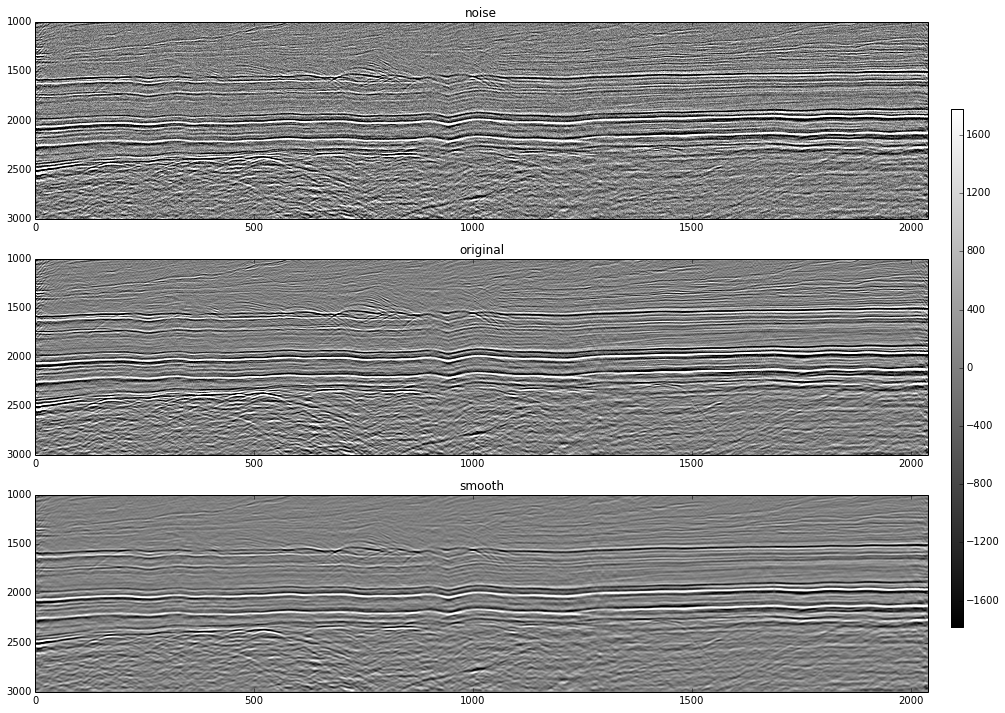